# 🛍️ Retail Sales Analysis – EDA & Business Insights

This notebook contains Exploratory Data Analysis and Business Insights derived from the Online Retail dataset using a Medallion Architecture (Bronze → Silver → Gold).

We use the Gold layer loaded in MySQL to extract insights such as:
- Top selling products
- Monthly revenue trends
- Country-wise order value
- Segmenting customers using RFM

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from urllib.parse import quote_plus

# MySQL Connection
user = "root"
host = "localhost"
password = quote_plus("MySqlDb@1")
database = "online_retail_data"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{database}")

Load Gold Layer Tables 

In [23]:
# Load gold sales and customer summary
df = pd.read_sql("SELECT * FROM sales_gold", engine)
customer_df = pd.read_sql("SELECT * FROM customers_gold", engine)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Name,Email,Phone,Address,SignupDate,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Alexis Robbins MD,neil63@example.com,None,"8939 Scott Junctions\nPort Glenn, FL 33662",2025-05-23,2010,2010-12,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Alexis Robbins MD,neil63@example.com,None,"8939 Scott Junctions\nPort Glenn, FL 33662",2025-05-23,2010,2010-12,1,8
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Alexis Robbins MD,neil63@example.com,None,"8939 Scott Junctions\nPort Glenn, FL 33662",2025-05-23,2010,2010-12,1,8
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Alexis Robbins MD,neil63@example.com,None,"8939 Scott Junctions\nPort Glenn, FL 33662",2025-05-23,2010,2010-12,1,8
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Alexis Robbins MD,neil63@example.com,None,"8939 Scott Junctions\nPort Glenn, FL 33662",2025-05-23,2010,2010-12,1,8


Analysis 1: Top 10 Selling Products 

C:\Users\user\AppData\Local\Temp\ipykernel_12456\3320577461.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


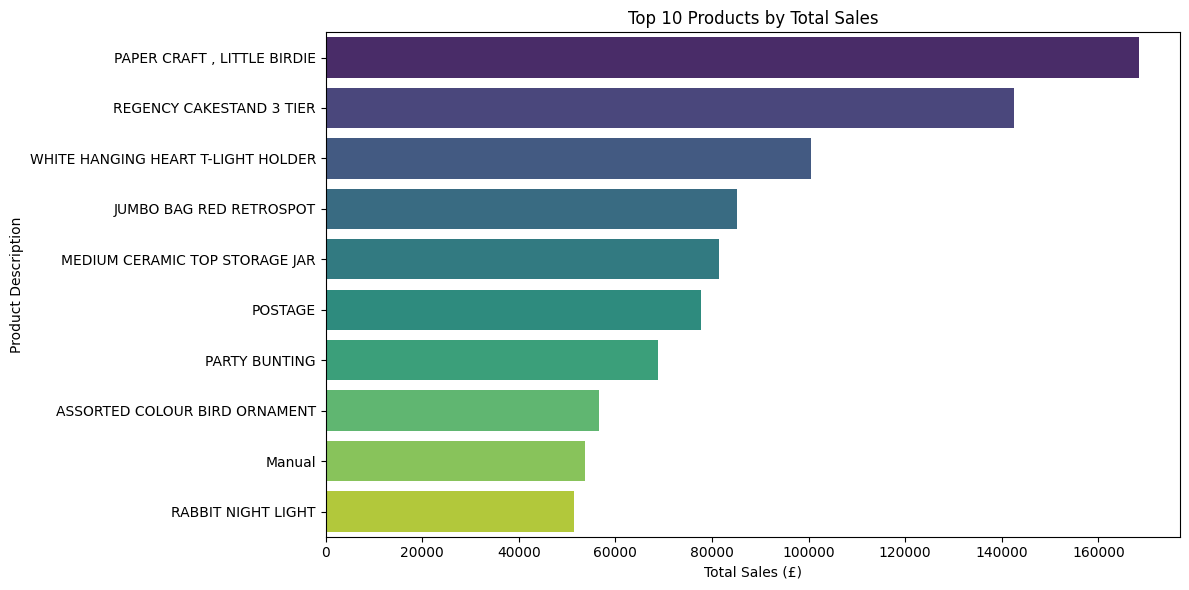

In [24]:
top_products = df.groupby("Description")["TotalPrice"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top 10 Products by Total Sales")
plt.xlabel("Total Sales (£)")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()

Analysis 2: Monthly Revenue Trend

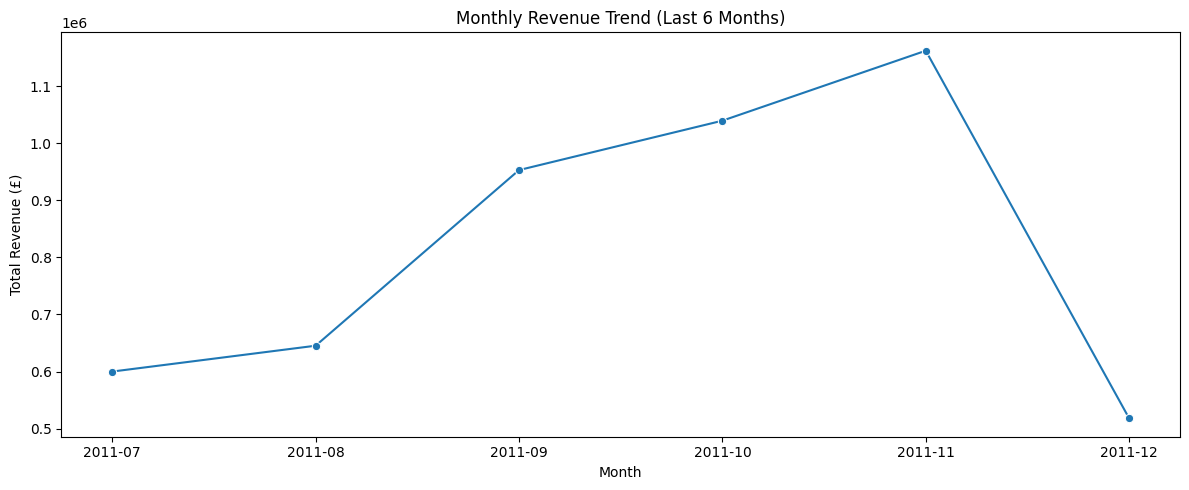

In [29]:
monthly_revenue = df.groupby(['InvoiceYear', 'InvoiceMonth'])['TotalPrice'].sum().reset_index()
monthly_revenue['Month'] = monthly_revenue['InvoiceMonth'].astype(str)
monthly_revenue = monthly_revenue.sort_values('Month')

last_6_months = monthly_revenue.tail(6).reset_index(drop=True)

plt.figure(figsize=(12,5))
sns.lineplot(data=last_6_months, x='Month', y='TotalPrice', marker='o')
plt.title('Monthly Revenue Trend (Last 6 Months)')
plt.xlabel('Month')
plt.ylabel('Total Revenue (£)')
plt.tight_layout()
plt.show()

Analysis 3: Average Order Value by Country (Top 10)

C:\Users\user\AppData\Local\Temp\ipykernel_12456\932278430.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.index, y=top_countries.values, palette="viridis")


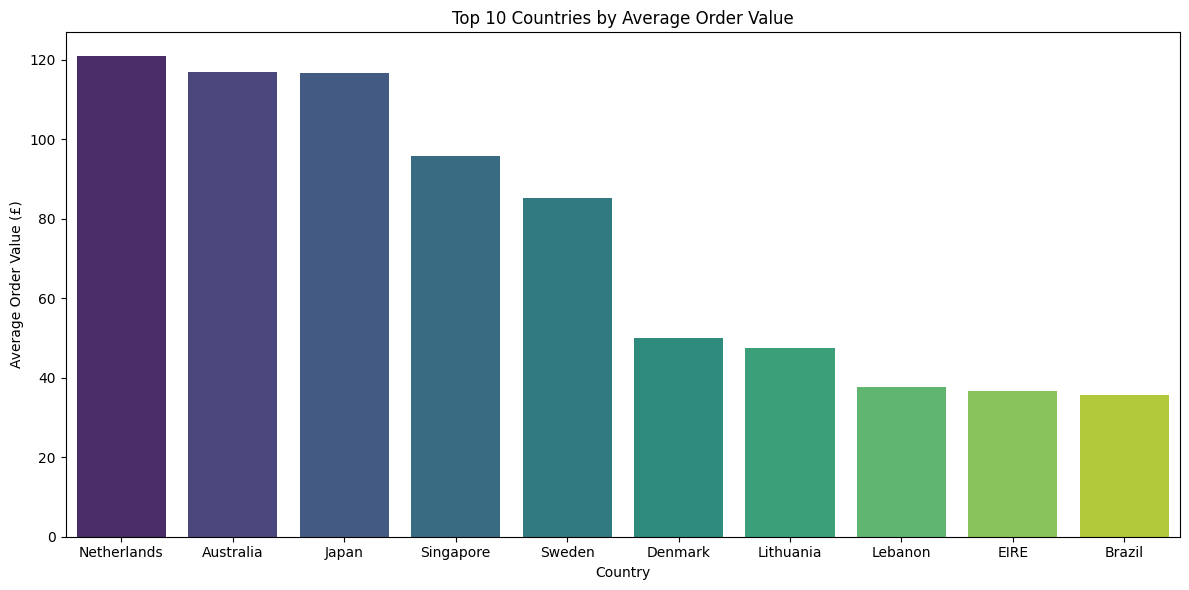

In [26]:
top_countries = df.groupby("Country")["TotalPrice"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_countries.index, y=top_countries.values, palette="viridis")
plt.title("Top 10 Countries by Average Order Value")
plt.xlabel("Country")
plt.ylabel("Average Order Value (£)")
plt.tight_layout()
plt.show()

Analysis 4: Top Products in Norway

C:\Users\user\AppData\Local\Temp\ipykernel_12456\1012164487.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=norway_sales.index, y=norway_sales.values, palette="viridis")


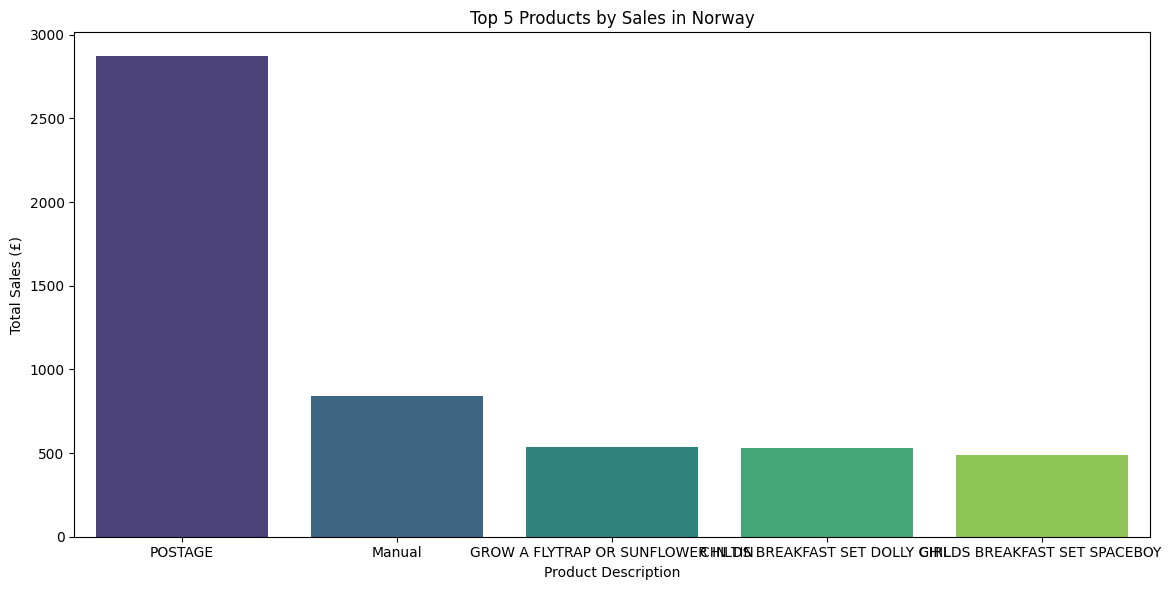

In [27]:
norway_sales = df[df["Country"] == "Norway"].groupby("Description")["TotalPrice"].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(12,6))
sns.barplot(x=norway_sales.index, y=norway_sales.values, palette="viridis")
plt.title("Top 5 Products by Sales in Norway")
plt.xlabel("Product Description")
plt.ylabel("Total Sales (£)")
plt.tight_layout()
plt.show()

Analysis 5: Customer Segmentation Using RFM

C:\Users\user\AppData\Local\Temp\ipykernel_12456\4166136808.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts, x='Segment', y='Customer Count', palette='Set2')


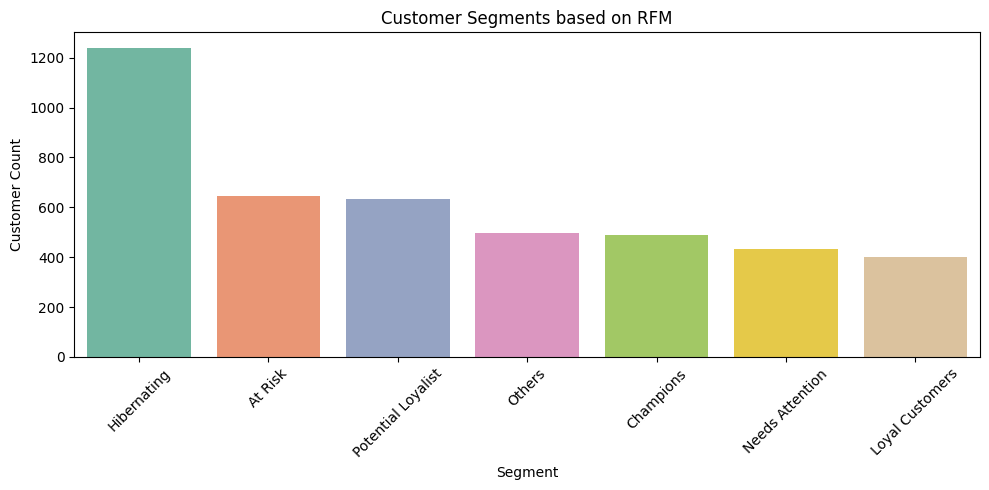

In [30]:
def segment_customer(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 4 and f >= 3:
        return 'Loyal Customers'
    elif r >= 3 and f >= 3:
        return 'Potential Loyalist'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Hibernating'
    elif r == 3:
        return 'Needs Attention'
    else:
        return 'Others'

customer_df['segment'] = customer_df.apply(segment_customer, axis=1)

segment_counts = customer_df['segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Customer Count']

plt.figure(figsize=(10, 5))
sns.barplot(data=segment_counts, x='Segment', y='Customer Count', palette='Set2')
plt.title('Customer Segments based on RFM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 📈 Key Takeaways:
- The top selling product is **Paper Craft** contributing £160k in sales.
- Monthly revenue peaked in **November**, suggesting seasonal trends.
- Norway’s top-selling items differ from UK and show localized demand.
- Champions and Loyal Customers account for the majority of value, indicating strong repeat engagement.

---

📁 This analysis uses the **Gold layer** from our Medallion architecture pipeline and demonstrates both business and technical understanding of ETL, data quality, and insight generation.